In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [53]:
import configuration
import data.constants as dconstants
import model.constants as mconstants
from data.build import load_data_from_configuration, load_base_data_from_configuration
from model.build import make_model
from data.util import data_get_num_attributes, data_get_num_classes
from train import train_model
from data.transform import PerturbationTransform
from torch_geometric.loader import DataLoader
import umap
from openTSNE import TSNE
from model.density import get_density_model
from model.prediction import SOFT_PREDICTIONS
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [5]:
data_cfg = configuration.DataConfiguration(
                        dataset='pubmed', 
                        train_portion=20, test_portion_fixed=0.2,
                        ood_type = dconstants.PERTURBATION,
                        setting = dconstants.HYBRID,
                        drop_train_vertices_portion = 0.1,
                        preprocessing='bag_of_words'
                        )

In [58]:
spectral_norm_cfg = {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 10.0,
    }

model_cfg = configuration.ModelConfiguration(
        model_type=mconstants.GCN,
        hidden_sizes=[64,], 
        use_bias=True, 
        activation='leaky_relu', 
        leaky_relu_slope=0.01,
        freeze_residual_projection=False, 
        use_spectral_norm_on_last_layer=True,
        use_residual_on_last_layer=False,
        self_loop_fill_value=1.0, 
        cached=True,
        **spectral_norm_cfg,
        )
training_cfg = configuration.TrainingConfiguration(
        max_epochs=1000, # 1000, 
        learning_rate=0.001, 
        early_stopping={
            'monitor' : 'val_loss',
            'mode' : 'min',
            'patience' : 50,
            'min_delta' : 1e-2,
        }, 
        gpus=0, 
        suppress_stdout=False, 
        weight_decay=1e-3,
        )

cfg = configuration.ExperimentConfiguration(model=model_cfg, data=data_cfg, training=training_cfg)

In [59]:
configuration.update_with_default_configuration(cfg)

In [60]:
# cfg.data.preprocessing = 'bag_of_words'

In [61]:
datasets, _ = load_data_from_configuration(cfg.data, 1337)

In [62]:
datasets[dconstants.TRAIN][0].x.size()

torch.Size([14355, 500])

In [63]:
pl.seed_everything(1337)
model = make_model(cfg, data_get_num_attributes(datasets[dconstants.TRAIN][0]), 
                data_get_num_classes(datasets[dconstants.TRAIN][0])) 

Global seed set to 1337


In [64]:
model

SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): ResidualBlock(
        (conv): GCNConv(500, 64)
        (act): LeakyReLU(negative_slope=0.01)
        (input_projection): LinearWithSpectralNormaliatzion(
          (linear): ParametrizedLinear(
            in_features=500, out_features=64, bias=True
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _SpectralNorm()
              )
            )
          )
        )
      )
      (1): BasicBlock(
        (conv): GCNConv(64, 3)
      )
    )
  )
)

In [65]:
data_loaders = {
            name : DataLoader(data, batch_size=1, shuffle=False) for name, data in datasets.items()
        }

In [66]:
cfg.run.use_pretrained_model

True

In [67]:
model = train_model(model, cfg, '~', data_loaders, logger=None).eval()

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ~ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.8166666626930237,
 'val_cross_entropy': 0.5964008569717407,
 'val_loss': 0.5964008569717407}
--------------------------------------------------------------------------------


In [68]:
data_ood = PerturbationTransform(noise_type='bernoulli', p=0.5)(datasets[dconstants.OOD_VAL][0])
data_train = datasets[dconstants.TRAIN][0]
data_val = datasets[dconstants.VAL][0]

In [69]:
with torch.no_grad():
    prediction_val = model(data_ood)
    prediction_train = model(data_train)

In [70]:
features_val = prediction_val.get_features(-2)
features_train = prediction_train.get_features(-2)
print(features_val.size())

torch.Size([19717, 64])


In [71]:
density = get_density_model('GaussianPerClass', covariance='diag')

In [72]:
# features_val[data_ood.mask].size(), data_ood.y[data_ood.mask].size()

soft_train = torch.zeros_like(prediction_train.get_logits())
soft_train[torch.arange(soft_train.size(0)), data_train.y] = 1.0




# soft_val = prediction_val.get(SOFT_PREDICTIONS)
density.fit(features_train[data_train.mask], soft_train[data_train.mask], features_train[data_val.mask], soft_train[data_val.mask])

In [73]:
density_val = density(features_val)
density_val_ood = density_val[data_ood.mask & data_ood.is_out_of_distribution]
density_val_id = density_val[data_ood.mask & ~data_ood.is_out_of_distribution]

auroc = roc_auc_score(
        (~data_ood.is_out_of_distribution[data_ood.mask]).long().cpu().numpy(),
        density_val[data_ood.mask].cpu().numpy(),
)
precision, recall, _ = precision_recall_curve(
        (~data_ood.is_out_of_distribution[data_ood.mask]).long().cpu().numpy(),
        density_val[data_ood.mask].cpu().numpy(),
)
aucpr = auc(recall, precision)
print(f'AUROC: {auroc:.4f}, AUCPR: {aucpr:.4f}')

AUROC: 0.9990, AUCPR: 0.9995


In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=2)
features_emb = pca.fit_transform(torch.cat([
    features_train[data_train.mask], features_val[data_ood.mask]], dim=0).numpy())
features_train_emb = features_emb[:features_train[data_train.mask].size(0)]
features_val_emb = features_emb[features_train[data_train.mask].size(0):]

In [20]:
is_ood = data_ood.is_out_of_distribution[data_ood.mask]

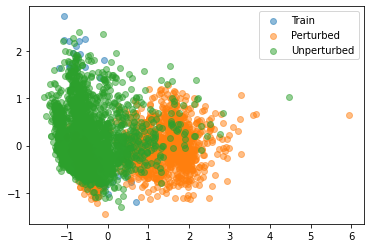

In [21]:
plt.scatter(features_train_emb[:, 0], features_train_emb[:, 1], label='Train', alpha=0.5)
plt.scatter(features_val_emb[:, 0][is_ood], features_val_emb[:, 1][is_ood], label='Perturbed', alpha=0.5)
plt.scatter(features_val_emb[:, 0][~is_ood], features_val_emb[:, 1][~is_ood], label='Unperturbed', alpha=0.5)
plt.legend()

In [22]:
logits_val = prediction_val.get_logits()
logits_train = prediction_train.get_logits()

In [23]:
tsne = TSNE(random_state=1337)

tsne_emb = tsne.fit(torch.cat([
    logits_train[data_train.mask], logits_val[data_ood.mask]
], dim=0).numpy())

logits_train_emb = tsne_emb[:logits_train[data_train.mask].size(0)]
logits_val_emb = tsne_emb[logits_train[data_train.mask].size(0):]


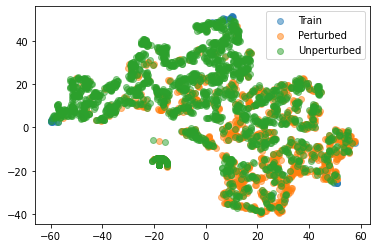

In [24]:
plt.scatter(logits_train_emb[:, 0], logits_train_emb[:, 1], label='Train', alpha=0.5)
plt.scatter(logits_val_emb[:, 0][is_ood], logits_val_emb[:, 1][is_ood], label='Perturbed', alpha=0.5)
plt.scatter(logits_val_emb[:, 0][~is_ood], logits_val_emb[:, 1][~is_ood], label='Unperturbed', alpha=0.5)
plt.legend()

In [25]:
lpca = PCA(n_components=2, random_state=1337)
logits_pemb = lpca.fit_transform(torch.cat([
    logits_train[data_train.mask], logits_val[data_ood.mask]
], dim=0).numpy())
logits_train_pemb = logits_pemb[:features_train[data_train.mask].size(0)]
logits_val_pemb = logits_pemb[features_train[data_train.mask].size(0):]

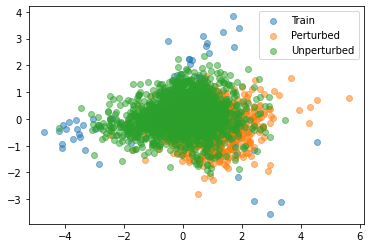

In [26]:
plt.scatter(logits_train_pemb[:, 0], logits_train_pemb[:, 1], label='Train', alpha=0.5)
plt.scatter(logits_val_pemb[:, 0][is_ood], logits_val_pemb[:, 1][is_ood], label='Perturbed', alpha=0.5)
plt.scatter(logits_val_pemb[:, 0][~is_ood], logits_val_pemb[:, 1][~is_ood], label='Unperturbed', alpha=0.5)
plt.legend()

## Investigate the weight matrices of the first convolution

In [27]:
conv = model.backbone.convs[0]
conv

ResidualBlock(
  (conv): GCNConv(500, 64)
  (act): LeakyReLU(negative_slope=0.01)
  (input_projection): LinearWithSpectralNormaliatzion(
    (linear): ParametrizedLinear(
      in_features=500, out_features=64, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
)

In [28]:
# SVD on the input projection
W_proj = conv.input_projection.linear.weight.detach().numpy()

In [29]:
W_conv = conv.conv.lin.weight.detach().numpy()

In [30]:
u_proj, s_proj, vh_proj = np.linalg.svd(W_proj, full_matrices=False)

In [31]:
', '.join([f'{sv:.1f}' for sv in s_proj])

'11.2, 9.1, 4.9, 4.5, 4.1, 4.0, 4.0, 3.9, 3.8, 3.8, 3.7, 3.6, 3.6, 3.6, 3.6, 3.5, 3.5, 3.5, 3.5, 3.4, 3.4, 3.3, 3.3, 3.2, 3.2, 3.2, 3.2, 3.1, 3.1, 3.1, 3.0, 3.0, 3.0, 2.9, 2.9, 2.9, 2.9, 2.8, 2.8, 2.7, 2.7, 2.7, 2.7, 2.7, 2.6, 2.6, 2.6, 2.5, 2.5, 2.5, 2.4, 2.4, 2.4, 2.3, 2.3, 2.3, 2.3, 2.2, 2.2, 2.1, 2.0, 1.9, 1.9, 1.8'

In [32]:
u_conv, s_conv, vh_conv = np.linalg.svd(W_conv, full_matrices=False)

In [33]:
', '.join([f'{sv:.1f}' for sv in s_conv])

'10.1, 9.9, 9.4, 8.5, 7.5, 7.2, 6.9, 6.7, 6.7, 6.5, 6.4, 6.3, 6.3, 6.1, 6.0, 6.0, 5.9, 5.8, 5.7, 5.6, 5.6, 5.5, 5.4, 5.4, 5.3, 5.3, 5.2, 5.2, 5.1, 5.0, 5.0, 4.9, 4.9, 4.8, 4.7, 4.7, 4.7, 4.7, 4.6, 4.5, 4.5, 4.3, 4.3, 4.3, 4.2, 4.2, 4.1, 4.1, 4.0, 3.9, 3.8, 3.8, 3.7, 3.6, 3.6, 3.6, 3.4, 3.4, 3.2, 3.2, 3.0, 2.9, 2.8, 2.7'

In [34]:


x_ood = data_ood.x[data_ood.mask & data_ood.is_out_of_distribution].numpy()
y_ood = data_ood.y[data_ood.mask & data_ood.is_out_of_distribution].numpy()
x_id = data_ood.x[data_ood.mask & ~data_ood.is_out_of_distribution].numpy()
y_id = data_ood.y[data_ood.mask & ~data_ood.is_out_of_distribution].numpy()

# Group by class
x_ood = x_ood[np.argsort(y_ood)]
x_id = x_id[np.argsort(y_id)]


In [35]:
x_ood.shape, x_id.shape

((1586, 500), (2729, 500))

Text(0.5, 1.0, 'Perturbed')

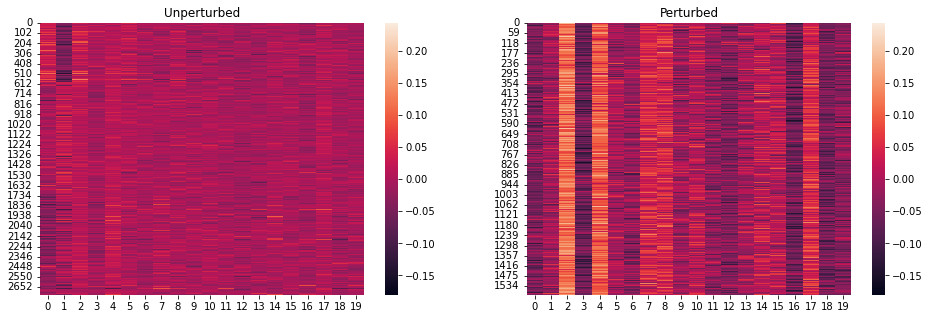

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
vmin = min((x_id @ vh_proj.T).min(), (x_ood @ vh_proj.T).min())
vmax = max((x_id @ vh_proj.T).max(), (x_ood @ vh_proj.T).max())

sns.heatmap((x_id @ vh_proj.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[0])
axs[0].set_title('Unperturbed')
sns.heatmap((x_ood @ vh_proj.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[1])
axs[1].set_title('Perturbed')

Text(0.5, 1.0, 'Perturbed')

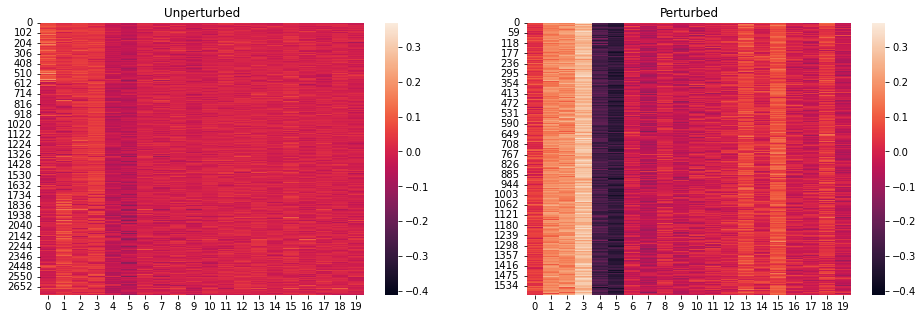

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
vmin = min((x_id @ vh_conv.T).min(), (x_ood @ vh_conv.T).min())
vmax = max((x_id @ vh_conv.T).max(), (x_ood @ vh_conv.T).max())
sns.heatmap((x_id @ vh_conv.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[0])
axs[0].set_title('Unperturbed')
sns.heatmap((x_ood @ vh_conv.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[1])
axs[1].set_title('Perturbed')

Text(0.5, 1.0, 'Distribution of weights for inputs Proj')

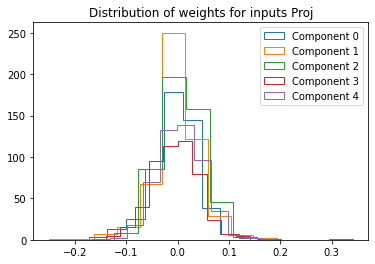

In [38]:
components = range(5)
fig, ax = plt.subplots()
for c in components:
    ax.hist(vh_proj[c], histtype='step', label='Component ' + str(c))
ax.legend()
ax.set_title('Distribution of weights for inputs Proj')

Text(0.5, 1.0, 'Distribution of weights for inputs Conv Weight')

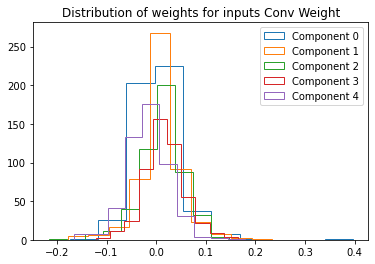

In [39]:
components = range(5)
fig, ax = plt.subplots()
for c in components:
    ax.hist(vh_conv[c], histtype='step',  label='Component ' + str(c))
ax.legend()
ax.set_title('Distribution of weights for inputs Conv Weight')

Text(0.5, 1.0, 'Fraction Non Zero OOD')

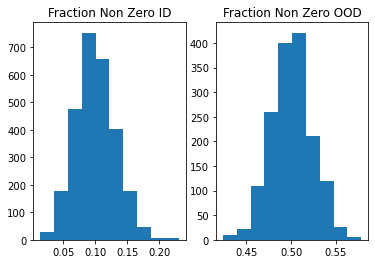

In [40]:
fig, axs = plt.subplots(1, 2)
axs[0].hist((x_id > 0).sum(1) / x_ood.shape[1])
axs[0].set_title('Fraction Non Zero ID')
axs[1].hist((x_ood > 0).sum(1) / x_ood.shape[1])
axs[1].set_title('Fraction Non Zero OOD')

In [41]:
#data_raw = np.load('./data/raw/cora_full.npz', allow_pickle=True)
#print(list(data_raw.keys()))
#idx_to_feature = data_raw['idx_to_attr'].item()

idx_to_feature = {int(idx) : feature for feature, idx in load_base_data_from_configuration(cfg.data).feature_to_idx.items()}

In [42]:
print('Strongest correlating words Proj Weight')
most_relevant = np.argsort(-np.abs(vh_proj), axis=1)
for i in range(10):
    most_relevant_i = most_relevant[i, :5]
    weights = vh_proj[i, :][most_relevant_i]
    words = [idx_to_feature[j] for j in most_relevant_i]
    
    print(f'Component {i} : ' + '\t' + ', '.join(words))
    #print('\t' + '\n\t'.join(f'{word} : {weight:.2f}' for weight, word in zip(weights, words)))
    

Strongest correlating words Proj Weight
Component 0 : 	feature_0, feature_274, feature_449, feature_202, feature_451
Component 1 : 	feature_0, feature_359, feature_386, feature_31, feature_16
Component 2 : 	feature_0, feature_52, feature_261, feature_196, feature_158
Component 3 : 	feature_79, feature_196, feature_471, feature_449, feature_235
Component 4 : 	feature_389, feature_356, feature_471, feature_235, feature_484
Component 5 : 	feature_381, feature_274, feature_15, feature_456, feature_444
Component 6 : 	feature_63, feature_261, feature_235, feature_432, feature_318
Component 7 : 	feature_449, feature_0, feature_426, feature_87, feature_130
Component 8 : 	feature_15, feature_101, feature_11, feature_41, feature_218
Component 9 : 	feature_0, feature_32, feature_38, feature_221, feature_9


In [43]:
print('Strongest correlating words Conv Weight')
most_relevant = np.argsort(-np.abs(vh_conv), axis=1)
for i in range(10):
    most_relevant_i = most_relevant[i, :5]
    weights = vh_conv[i, :][most_relevant_i]
    words = [idx_to_feature[j] for j in most_relevant_i]
    
    print(f'Component {i} : ' + '\t' + ', '.join(words))
    #print('\t' + '\n\t'.join(f'{word} : {weight:.2f}' for weight, word in zip(weights, words)))
    

Strongest correlating words Conv Weight
Component 0 : 	feature_0, feature_285, feature_89, feature_8, feature_52
Component 1 : 	feature_449, feature_359, feature_451, feature_16, feature_274
Component 2 : 	feature_274, feature_261, feature_400, feature_443, feature_325
Component 3 : 	feature_360, feature_162, feature_432, feature_325, feature_438
Component 4 : 	feature_0, feature_49, feature_162, feature_149, feature_423
Component 5 : 	feature_477, feature_320, feature_15, feature_329, feature_357
Component 6 : 	feature_274, feature_221, feature_91, feature_8, feature_15
Component 7 : 	feature_0, feature_477, feature_386, feature_202, feature_2
Component 8 : 	feature_196, feature_346, feature_360, feature_160, feature_89
Component 9 : 	feature_119, feature_301, feature_32, feature_488, feature_90
